In [ ]:
!pip install torchsummary

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
import json
from torchsummary import summary
from collections import Counter
from sklearn.metrics import accuracy_score, f1_score
import cv2
from tqdm import tqdm
import os
from random import random
from google.colab.patches import cv2_imshow

In [ ]:
# configurations
image_size = 224
batch_size = 32
num_workers = 2
learning_rate = 1e-4
num_epoch = 10

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Celebrity Faces Dataset'

Mounted at /content/drive


In [ ]:
# Define the transformations for the training data (with data augmentation)
train_transform = transforms.Compose([
    transforms.RandomRotation(degrees = 10),
    transforms.RandomHorizontalFlip(p = 0.3),
    transforms.RandomGrayscale(p = 0.3),
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # Normalize using ImageNet values
])

# Define the transformations for the validation data (without augmentation)
val_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor(),                 # Convert images to tensors
])

In [ ]:
dataset = datasets.ImageFolder(root = path)

In [ ]:
# Train-validation split

# random spliting
trainRatio = 0.80
trainSize = int(trainRatio * len(dataset))
valSize = len(dataset) - trainSize

# Set a manual seed
generator = torch.Generator().manual_seed(10)
train_set, val_set = random_split(dataset, [trainSize, valSize], generator=generator)

In [ ]:
# Apply the transformations manually to each split
train_set.dataset.transform = train_transform  # Augment only training data
val_set.dataset.transform = val_transform      # No augmentation for validation

In [ ]:
# Data loaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [ ]:
# Function to count samples per class
def count_samples_per_class(dataset):
    labels = [label for _, label in dataset]
    label_count = Counter(labels)
    return label_count

In [ ]:
label_count = count_samples_per_class(train_set)
num_classes = len(label_count)
print("Total number of data: ", len(train_set))
print("Number of classes:", num_classes)
print("Number of data samples per class:", label_count)

Total number of data:  1440
Number of classes: 17
Number of data samples per class: Counter({13: 156, 12: 84, 14: 84, 0: 84, 1: 83, 10: 83, 4: 81, 6: 80, 5: 80, 8: 80, 11: 80, 9: 80, 15: 79, 7: 79, 16: 78, 2: 75, 3: 74})


In [ ]:
label_count = count_samples_per_class(val_set)
num_classes = len(label_count)
print("Total number of data: ", len(val_set))
print("Number of classes:", num_classes)
print("Number of data samples per class:", label_count)

Total number of data:  360
Number of classes: 17
Number of data samples per class: Counter({13: 44, 3: 26, 2: 25, 16: 22, 15: 21, 7: 21, 8: 20, 11: 20, 6: 20, 9: 20, 5: 20, 4: 19, 10: 17, 1: 17, 0: 16, 14: 16, 12: 16})


In [ ]:
cat_to_name = {'1': 'Angelina Jolie', '2': 'Brad Pitt', '3': 'Denzel Washington', '4':'Hugh Jackman', '5':'Jennifer Lawrence', '6':'Johnny Depp', '7':'Kate Winslet', '8':'Leonardo DiCaprio', '9':'Megan Fox', '10':'Natalie Portman', '11':'Nicole Kidman', '12':'Robert Downey Jr', '13':'Sandra Bullock', '14':'Scarlett Johansson', '15':'Tom Cruise', '16':'Tom Hanks', '17':'Will Smith' }
def imshow(img_tensor, ax, label):
    """ Utility function to display an image tensor with a caption. """
    if img_tensor.shape[0] == 3:  # Check if it's an RGB image
        ax.imshow(img_tensor.permute(1, 2, 0))  # Reorder dimensions to (height, width, channels)
    else:
        ax.imshow(img_tensor[0], cmap='gray')  # Display the first channel (grayscale)
    ax.axis('off')
    ax.set_title(label, fontsize=10)

def show_images_batch(images_batch, labels):
    """
    Display a batch of images in a grid with labels.
    """

    batch_size = images_batch.shape[0]
    grid_cols = int(np.ceil(np.sqrt(batch_size)))
    grid_rows = int(np.ceil(batch_size / grid_cols))  # Ensure all images fit in the grid

    fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(grid_cols * 2.5, grid_rows * 2.5))
    if grid_rows * grid_cols == 1:  # Special case for single image
        axes = [axes]  # Make it iterable

    # Check if axes is still not iterable
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])


    for i in range(grid_rows * grid_cols):
        ax = axes.flatten()[i]
        if i < batch_size:
            # imshow(images_batch[i], ax, labels[i].item())
            imshow(images_batch[i], ax, cat_to_name[str(labels[i].item() + 1)])
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

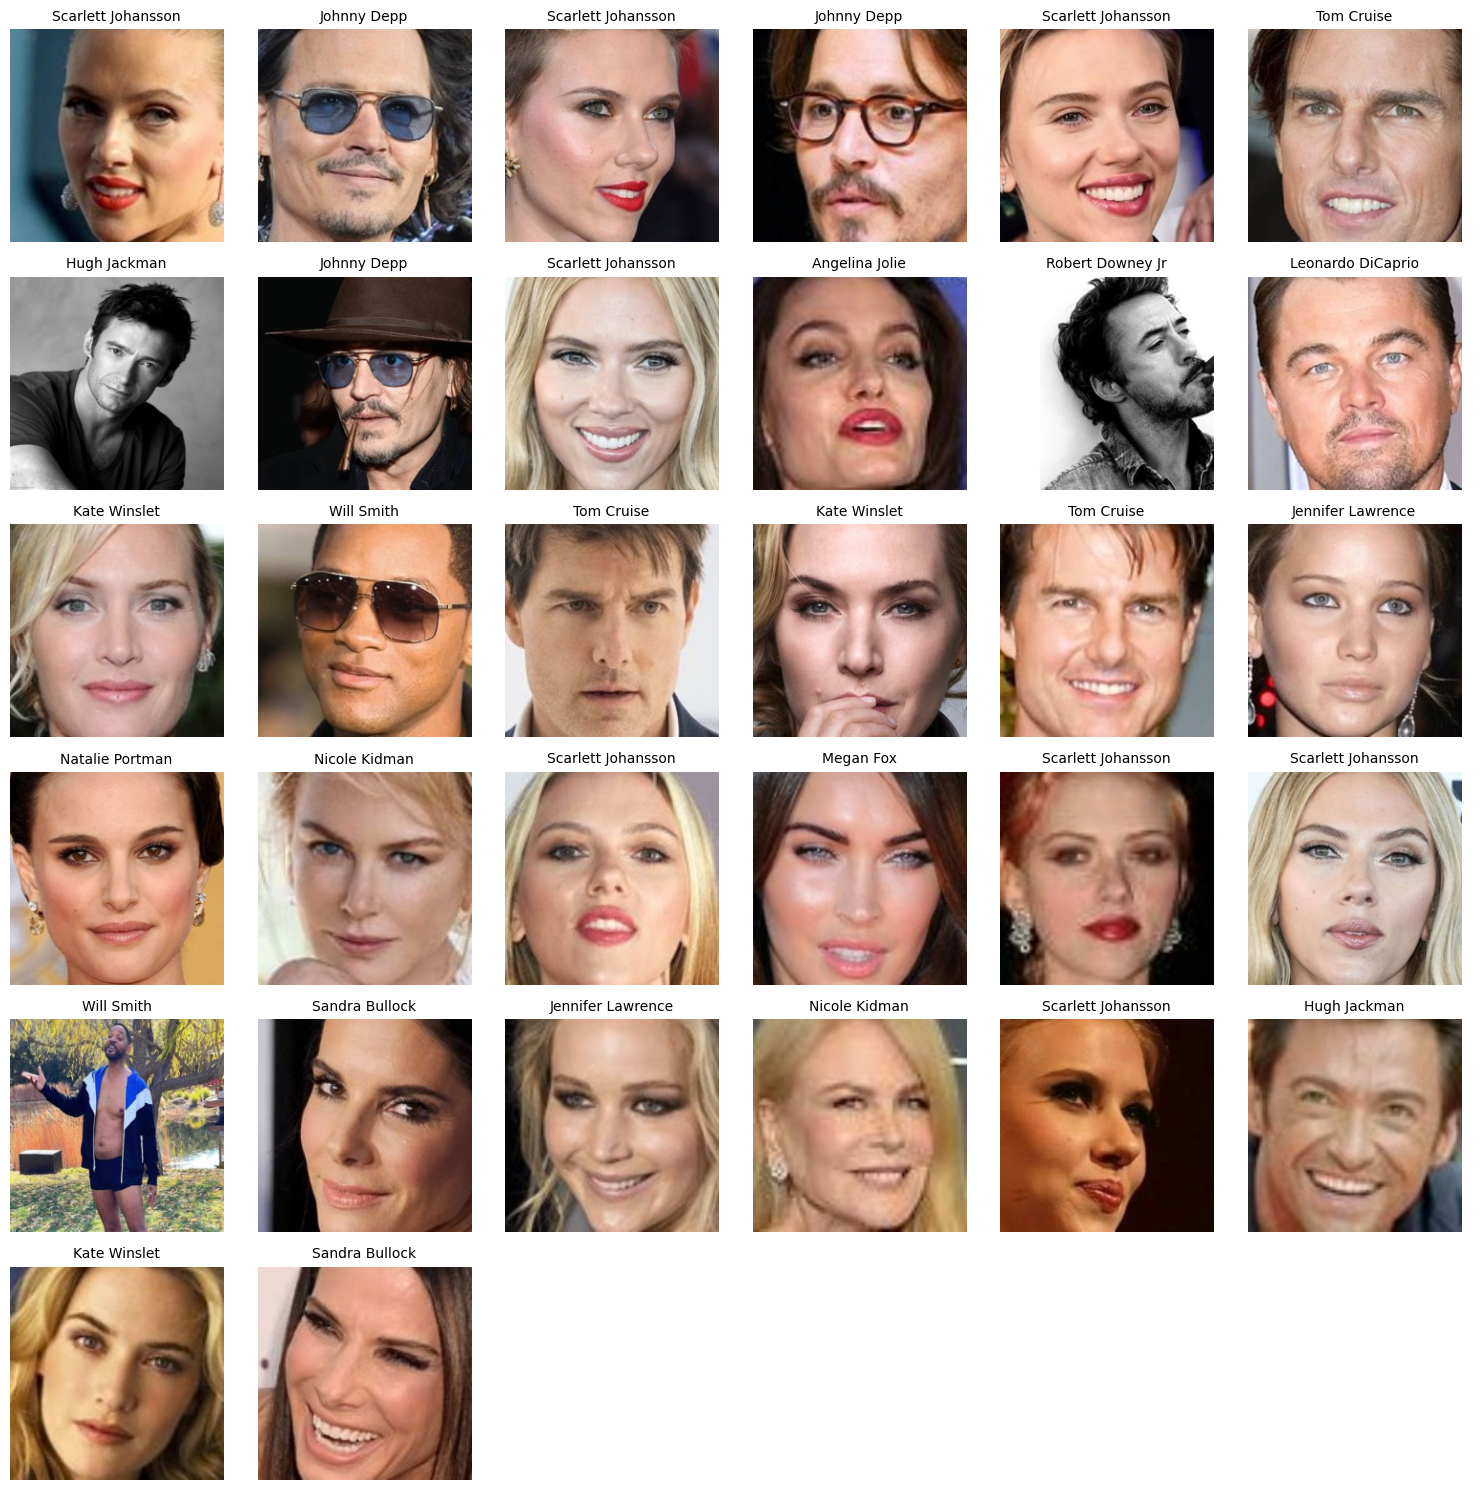

In [ ]:
for idx, data in enumerate(train_loader):

  show_images_batch(images_batch=data[0], labels=data[1])
  break

## CNN Model with Augmentation

In [ ]:
#resnet_model = torchvision.models.resnet50(weights='IMAGENET1K_V2').cuda()
resnet_model = torchvision.models.resnet18(weights='IMAGENET1K_V1').cuda()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 122MB/s]


In [ ]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
# change output from 512 to 17 at the last layer
resnet_model.fc = nn.Linear(512, 17)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate, weight_decay=1e-4)

In [ ]:
resnet_model = resnet_model.cuda()

In [ ]:
val_running_loss = 0.0
val_running_accuracy = 0.0
idx = 0
for idx, data in enumerate(val_loader):


  images, labels = data
  images = images.cuda()
  labels = labels.cuda()
  #images = images
  #labels = labels

  pred = resnet_model(images)

  loss = loss_fn(pred, labels)

  val_running_loss += loss.item()

  _, pred_arr = torch.max(pred.detach(), 1)
  label_arr = labels.cpu().numpy()

  val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())


  if idx == 10:
    break

print(f"Validation Loss is {val_running_loss}")
print(f"Validation Accuracy is {val_running_accuracy/(idx+1)}")

Validation Loss is 32.104602098464966
Validation Accuracy is 0.09090909090909091


##Only retrain the output layer

In [ ]:
# freezing layer
# when requires_grad is set to false then is freeze
for p in resnet_model.parameters():
  p.requires_grad = False

In [ ]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
# reinitilized again to retrain the last layer
# in default requires_grad is set to true at this moment
resnet_model.fc = nn.Linear(512, 17)

In [ ]:
resnet_model = resnet_model.cuda()

In [ ]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
# training part only on the last layer
best_val_accuracy = 0
for epoch_idx in range(num_epoch):

  train_running_loss = 0.0
  train_running_accuracy = 0.0

  idx = 0
  for idx, data in tqdm(enumerate(train_loader)):

    optimizer.zero_grad()

    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    #images = images
    #labels = labels

    pred = resnet_model(images)

    loss = loss_fn(pred, labels)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()


    train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
  print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")

45it [00:12,  3.47it/s]

Training Loss at epoch 0 is 128.17705464363098
Training Accuracy at epoch 0 is 0.04722222222222222



45it [00:12,  3.56it/s]

Training Loss at epoch 1 is 128.2195656299591
Training Accuracy at epoch 1 is 0.049305555555555554



45it [00:13,  3.22it/s]

Training Loss at epoch 2 is 128.2389838695526
Training Accuracy at epoch 2 is 0.05277777777777778



45it [00:12,  3.54it/s]

Training Loss at epoch 3 is 128.20736527442932
Training Accuracy at epoch 3 is 0.044444444444444446



45it [00:13,  3.22it/s]

Training Loss at epoch 4 is 128.23621559143066
Training Accuracy at epoch 4 is 0.04861111111111111



45it [00:14,  3.05it/s]

Training Loss at epoch 5 is 128.24780440330505
Training Accuracy at epoch 5 is 0.04583333333333333



45it [00:16,  2.77it/s]

Training Loss at epoch 6 is 128.16206121444702
Training Accuracy at epoch 6 is 0.04861111111111111



45it [00:13,  3.26it/s]

Training Loss at epoch 7 is 128.16610312461853
Training Accuracy at epoch 7 is 0.04236111111111111



45it [00:10,  4.20it/s]

Training Loss at epoch 8 is 128.15001845359802
Training Accuracy at epoch 8 is 0.04652777777777778



45it [00:11,  3.76it/s]

Training Loss at epoch 9 is 128.2412760257721
Training Accuracy at epoch 9 is 0.044444444444444446


##Retraining more layers

In [ ]:
for n, p in resnet_model.named_parameters():
  print(n)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [ ]:
for p in resnet_model.named_parameters():
  # print(p[0])
  if 'layer4' in p[0]:
    p[1].requires_grad = True

In [ ]:
summary(resnet_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Day 3 testing using resnet18

In [ ]:
import joblib
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
num_epoch = 30
for epoch_idx in range(num_epoch):

  train_running_loss = 0.0
  train_running_accuracy = 0.0

  idx = 0
  for idx, data in tqdm(enumerate(train_loader)):

    optimizer.zero_grad()

    images, labels = data
    # if using CPU then should comment this cuda
    images = images.cuda()
    labels = labels.cuda()

    pred = resnet_model(images)

    loss = loss_fn(pred, labels)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()


    train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
  print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")
  train_losses.append(train_running_loss)
  train_accuracies.append(train_running_accuracy)

  val_running_loss = 0.0
  val_running_accuracy = 0.0
  idx = 0
  for idx, data in tqdm(enumerate(val_loader)):


    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    pred = resnet_model(images)

    loss = loss_fn(pred, labels)

    val_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()


    val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  print(f"Validation Loss at epoch {epoch_idx} is {val_running_loss}")
  print(f"Validation Accuracy at epoch {epoch_idx} is {val_running_accuracy/(idx+1)}")
  val_losses.append(val_running_loss)
  val_accuracies.append(val_running_accuracy)


  if best_val_accuracy < val_running_accuracy/idx:

    torch.save(resnet_model.state_dict(), f"saved_model-{epoch_idx}.pth.tar")
    best_val_accuracy = val_running_accuracy/idx

    print(f"Model saved at epoch {epoch_idx} with val accuracy of {best_val_accuracy}")

# Save the model
joblib.dump(resnet_model, 'resnet_model.joblib')

45it [00:06,  7.39it/s]

Training Loss at epoch 0 is 98.56551575660706
Training Accuracy at epoch 0 is 0.3680555555555556



12it [00:02,  5.43it/s]


Validation Loss at epoch 0 is 16.184905409812927
Validation Accuracy at epoch 0 is 0.7109375
Model saved at epoch 0 with val accuracy of 0.7755681818181818


45it [00:06,  6.56it/s]

Training Loss at epoch 1 is 35.80243742465973
Training Accuracy at epoch 1 is 0.8840277777777777



12it [00:01,  7.66it/s]

Validation Loss at epoch 1 is 10.35277247428894
Validation Accuracy at epoch 1 is 0.8177083333333334
Model saved at epoch 1 with val accuracy of 0.8920454545454546



45it [00:06,  6.45it/s]

Training Loss at epoch 2 is 15.41495068371296
Training Accuracy at epoch 2 is 0.9722222222222222



12it [00:02,  4.54it/s]

Validation Loss at epoch 2 is 8.29996657371521
Validation Accuracy at epoch 2 is 0.84375
Model saved at epoch 2 with val accuracy of 0.9204545454545454



45it [00:06,  7.34it/s]

Training Loss at epoch 3 is 7.077163904905319
Training Accuracy at epoch 3 is 0.9972222222222222



12it [00:01,  7.72it/s]

Validation Loss at epoch 3 is 7.219279438257217
Validation Accuracy at epoch 3 is 0.8619791666666666
Model saved at epoch 3 with val accuracy of 0.9403409090909091



45it [00:08,  5.39it/s]

Training Loss at epoch 4 is 3.8602335937321186
Training Accuracy at epoch 4 is 1.0



12it [00:01,  7.72it/s]

Validation Loss at epoch 4 is 6.711166858673096
Validation Accuracy at epoch 4 is 0.8645833333333334
Model saved at epoch 4 with val accuracy of 0.9431818181818182



45it [00:05,  7.82it/s]

Training Loss at epoch 5 is 2.277198374271393
Training Accuracy at epoch 5 is 1.0



12it [00:01,  7.85it/s]


Validation Loss at epoch 5 is 6.286291539669037
Validation Accuracy at epoch 5 is 0.8671875
Model saved at epoch 5 with val accuracy of 0.9460227272727273


45it [00:08,  5.50it/s]

Training Loss at epoch 6 is 1.6546674277633429
Training Accuracy at epoch 6 is 1.0



12it [00:01,  8.07it/s]

Validation Loss at epoch 6 is 6.053704142570496
Validation Accuracy at epoch 6 is 0.8671875



45it [00:05,  7.83it/s]

Training Loss at epoch 7 is 1.4306513797491789
Training Accuracy at epoch 7 is 1.0



12it [00:02,  5.69it/s]


Validation Loss at epoch 7 is 5.80901899933815
Validation Accuracy at epoch 7 is 0.8723958333333334
Model saved at epoch 7 with val accuracy of 0.9517045454545454


45it [00:07,  6.32it/s]

Training Loss at epoch 8 is 1.0519220400601625
Training Accuracy at epoch 8 is 1.0



12it [00:01,  7.60it/s]

Validation Loss at epoch 8 is 5.711254715919495
Validation Accuracy at epoch 8 is 0.8828125
Model saved at epoch 8 with val accuracy of 0.9630681818181818



45it [00:06,  6.60it/s]

Training Loss at epoch 9 is 0.7833323841914535
Training Accuracy at epoch 9 is 1.0



12it [00:02,  4.67it/s]


Validation Loss at epoch 9 is 5.593504428863525
Validation Accuracy at epoch 9 is 0.8854166666666666
Model saved at epoch 9 with val accuracy of 0.9659090909090909


45it [00:05,  7.73it/s]

Training Loss at epoch 10 is 0.6931694354861975
Training Accuracy at epoch 10 is 1.0



12it [00:01,  7.82it/s]

Validation Loss at epoch 10 is 5.476641520857811
Validation Accuracy at epoch 10 is 0.8776041666666666



45it [00:08,  5.51it/s]

Training Loss at epoch 11 is 0.5990696027874947
Training Accuracy at epoch 11 is 1.0



12it [00:01,  7.98it/s]

Validation Loss at epoch 11 is 5.3897800743579865
Validation Accuracy at epoch 11 is 0.8802083333333334



45it [00:05,  7.71it/s]

Training Loss at epoch 12 is 0.5286609348841012
Training Accuracy at epoch 12 is 1.0



12it [00:01,  8.14it/s]

Validation Loss at epoch 12 is 5.341883808374405
Validation Accuracy at epoch 12 is 0.8802083333333334



45it [00:07,  5.68it/s]

Training Loss at epoch 13 is 0.4692676877602935
Training Accuracy at epoch 13 is 1.0



12it [00:01,  7.97it/s]

Validation Loss at epoch 13 is 5.287754416465759
Validation Accuracy at epoch 13 is 0.8828125



45it [00:05,  7.68it/s]

Training Loss at epoch 14 is 0.43336370633915067
Training Accuracy at epoch 14 is 1.0



12it [00:01,  6.55it/s]

Validation Loss at epoch 14 is 5.225022718310356
Validation Accuracy at epoch 14 is 0.8802083333333334



45it [00:07,  6.04it/s]

Training Loss at epoch 15 is 0.3638491681776941
Training Accuracy at epoch 15 is 1.0



12it [00:01,  7.95it/s]

Validation Loss at epoch 15 is 5.178408935666084
Validation Accuracy at epoch 15 is 0.8802083333333334



45it [00:06,  7.14it/s]

Training Loss at epoch 16 is 0.34284959034994245
Training Accuracy at epoch 16 is 1.0



12it [00:02,  4.85it/s]

Validation Loss at epoch 16 is 5.1065292954444885
Validation Accuracy at epoch 16 is 0.8828125



45it [00:07,  5.64it/s]

Training Loss at epoch 17 is 0.3299270235002041
Training Accuracy at epoch 17 is 1.0



12it [00:01,  7.99it/s]

Validation Loss at epoch 17 is 5.07873173058033
Validation Accuracy at epoch 17 is 0.8828125



45it [00:08,  5.56it/s]

Training Loss at epoch 18 is 0.3218342252075672
Training Accuracy at epoch 18 is 1.0



12it [00:01,  7.85it/s]

Validation Loss at epoch 18 is 5.040669269859791
Validation Accuracy at epoch 18 is 0.8932291666666666
Model saved at epoch 18 with val accuracy of 0.9744318181818182



45it [00:05,  7.54it/s]

Training Loss at epoch 19 is 0.25483550876379013
Training Accuracy at epoch 19 is 1.0



12it [00:02,  5.72it/s]

Validation Loss at epoch 19 is 5.003516532480717
Validation Accuracy at epoch 19 is 0.8854166666666666



45it [00:07,  6.09it/s]

Training Loss at epoch 20 is 0.24576522060669959
Training Accuracy at epoch 20 is 1.0



12it [00:01,  7.69it/s]

Validation Loss at epoch 20 is 4.978310540318489
Validation Accuracy at epoch 20 is 0.8854166666666666



45it [00:06,  7.03it/s]

Training Loss at epoch 21 is 0.23766811634413898
Training Accuracy at epoch 21 is 1.0



12it [00:02,  5.03it/s]

Validation Loss at epoch 21 is 4.939834199845791
Validation Accuracy at epoch 21 is 0.8854166666666666



45it [00:05,  7.70it/s]

Training Loss at epoch 22 is 0.21727334172464907
Training Accuracy at epoch 22 is 1.0



12it [00:01,  7.78it/s]


Validation Loss at epoch 22 is 4.917366124689579
Validation Accuracy at epoch 22 is 0.8880208333333334


45it [00:09,  4.84it/s]

Training Loss at epoch 23 is 0.1946478383615613
Training Accuracy at epoch 23 is 1.0



12it [00:02,  5.89it/s]

Validation Loss at epoch 23 is 4.884372375905514
Validation Accuracy at epoch 23 is 0.890625



45it [00:06,  7.15it/s]

Training Loss at epoch 24 is 0.1931239035911858
Training Accuracy at epoch 24 is 1.0



12it [00:01,  6.20it/s]

Validation Loss at epoch 24 is 4.871365271508694
Validation Accuracy at epoch 24 is 0.890625



45it [00:07,  5.99it/s]

Training Loss at epoch 25 is 0.1910041319206357
Training Accuracy at epoch 25 is 1.0



12it [00:01,  7.86it/s]

Validation Loss at epoch 25 is 4.84126952290535
Validation Accuracy at epoch 25 is 0.890625



45it [00:06,  6.77it/s]

Training Loss at epoch 26 is 0.1866047342773527
Training Accuracy at epoch 26 is 1.0



12it [00:02,  4.84it/s]

Validation Loss at epoch 26 is 4.841586999595165
Validation Accuracy at epoch 26 is 0.8854166666666666



45it [00:06,  7.43it/s]

Training Loss at epoch 27 is 0.17149020871147513
Training Accuracy at epoch 27 is 1.0



12it [00:01,  7.75it/s]

Validation Loss at epoch 27 is 4.836874686181545
Validation Accuracy at epoch 27 is 0.8854166666666666



45it [00:07,  5.71it/s]

Training Loss at epoch 28 is 0.14301601727493107
Training Accuracy at epoch 28 is 1.0



12it [00:01,  7.88it/s]

Validation Loss at epoch 28 is 4.783447585999966
Validation Accuracy at epoch 28 is 0.890625



45it [00:06,  7.24it/s]

Training Loss at epoch 29 is 0.14776589768007398
Training Accuracy at epoch 29 is 1.0



12it [00:01,  6.27it/s]


Validation Loss at epoch 29 is 4.763395361602306
Validation Accuracy at epoch 29 is 0.8958333333333334
Model saved at epoch 29 with val accuracy of 0.9772727272727273


['resnet_model.joblib']

In [ ]:
%%writefile app.py
import streamlit as st
import cv2
import numpy as np
import joblib
from PIL import Image

# Load the model
#model_path = 'face_classifier.pth'  # Replace with your model file name
#model = torch.load(model_path, map_location=torch.device('cpu'))

# Load the model and label encoder
model = joblib.load('resnet_model.joblib'. map_location=torch.device('cpu'))
#le = joblib.load('label_encoder.joblib')

# Define the prediction function
def predict(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    image = cv2.resize(image, (224, 224))  # Resize to the standard size
    image_flatten = image.flatten().reshape(1, -1)  # Flatten the image for the model
    prediction = model.predict(image_flatten)
    return prediction

# Create the Streamlit interface
st.title("Face Classification App")
st.write("Upload a face image for classification.")

uploaded_file = st.file_uploader("Choose an image...", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Read the image
    image = Image.open(uploaded_file)

    st.image(image, caption='Uploaded Image', use_column_width=True)

    if st.button("Classify"):
        result = predict(image)
        st.success(f"Prediction: {result}")



Writing app.py


## latest

In [ ]:
import torch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0
num_epoch = 30
for epoch_idx in range(num_epoch):

  train_running_loss = 0.0
  train_running_accuracy = 0.0

  idx = 0
  for idx, data in tqdm(enumerate(train_loader)):

    optimizer.zero_grad()

    images, labels = data
    # if using CPU then should comment this cuda
    images = images.cuda()
    labels = labels.cuda()

    pred = resnet_model(images)

    loss = loss_fn(pred, labels)

    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()


    train_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  print(f"Training Loss at epoch {epoch_idx} is {train_running_loss}")
  print(f"Training Accuracy at epoch {epoch_idx} is {train_running_accuracy/(idx+1)}")
  train_losses.append(train_running_loss)
  train_accuracies.append(train_running_accuracy)

  val_running_loss = 0.0
  val_running_accuracy = 0.0
  idx = 0
  for idx, data in tqdm(enumerate(val_loader)):


    images, labels = data
    images = images.cuda()
    labels = labels.cuda()

    pred = resnet_model(images)

    loss = loss_fn(pred, labels)

    val_running_loss += loss.item()

    _, pred_arr = torch.max(pred.detach(), 1)
    label_arr = labels.cpu().numpy()


    val_running_accuracy += accuracy_score(label_arr, pred_arr.cpu().numpy())

  print(f"Validation Loss at epoch {epoch_idx} is {val_running_loss}")
  print(f"Validation Accuracy at epoch {epoch_idx} is {val_running_accuracy/(idx+1)}")
  val_losses.append(val_running_loss)
  val_accuracies.append(val_running_accuracy)


  if best_val_accuracy < val_running_accuracy/idx:

    torch.save(resnet_model.state_dict(), f"saved_model-{epoch_idx}.pth.tar")
    best_val_accuracy = val_running_accuracy/idx

    print(f"Model saved at epoch {epoch_idx} with val accuracy of {best_val_accuracy}")

# Save the model
torch.save(resnet_model, 'resnet_model.pth')

45it [00:08,  5.18it/s]

Training Loss at epoch 0 is 88.96091413497925
Training Accuracy at epoch 0 is 0.43472222222222223



12it [00:01,  7.56it/s]

Validation Loss at epoch 0 is 13.82833057641983
Validation Accuracy at epoch 0 is 0.7369791666666666
Model saved at epoch 0 with val accuracy of 0.8039772727272727



45it [00:05,  7.60it/s]

Training Loss at epoch 1 is 29.629652321338654
Training Accuracy at epoch 1 is 0.90625



12it [00:01,  6.63it/s]


Validation Loss at epoch 1 is 8.444665908813477
Validation Accuracy at epoch 1 is 0.8697916666666666
Model saved at epoch 1 with val accuracy of 0.9488636363636364


45it [00:08,  5.43it/s]

Training Loss at epoch 2 is 12.163242980837822
Training Accuracy at epoch 2 is 0.9854166666666667



12it [00:01,  7.58it/s]

Validation Loss at epoch 2 is 6.461471855640411
Validation Accuracy at epoch 2 is 0.9036458333333334
Model saved at epoch 2 with val accuracy of 0.9857954545454546



45it [00:08,  5.40it/s]

Training Loss at epoch 3 is 5.597797803580761
Training Accuracy at epoch 3 is 0.9972222222222222



12it [00:01,  6.16it/s]

Validation Loss at epoch 3 is 5.554235547780991
Validation Accuracy at epoch 3 is 0.9166666666666666
Model saved at epoch 3 with val accuracy of 1.0



45it [00:07,  6.02it/s]

Training Loss at epoch 4 is 3.001542255282402
Training Accuracy at epoch 4 is 1.0



12it [00:01,  7.19it/s]

Validation Loss at epoch 4 is 5.096803277730942
Validation Accuracy at epoch 4 is 0.9192708333333334
Model saved at epoch 4 with val accuracy of 1.0028409090909092



45it [00:08,  5.54it/s]

Training Loss at epoch 5 is 1.9841245338320732
Training Accuracy at epoch 5 is 1.0



12it [00:01,  7.58it/s]

Validation Loss at epoch 5 is 4.839372083544731
Validation Accuracy at epoch 5 is 0.9192708333333334



45it [00:07,  6.08it/s]

Training Loss at epoch 6 is 1.3137352224439383
Training Accuracy at epoch 6 is 1.0



12it [00:03,  3.33it/s]

Validation Loss at epoch 6 is 4.58825346827507
Validation Accuracy at epoch 6 is 0.9192708333333334



45it [00:06,  7.46it/s]

Training Loss at epoch 7 is 1.0191771211102605
Training Accuracy at epoch 7 is 1.0



12it [00:02,  4.52it/s]


Validation Loss at epoch 7 is 4.4079407304525375
Validation Accuracy at epoch 7 is 0.921875
Model saved at epoch 7 with val accuracy of 1.0056818181818181


45it [00:08,  5.16it/s]

Training Loss at epoch 8 is 0.811455694027245
Training Accuracy at epoch 8 is 1.0



12it [00:01,  7.57it/s]

Validation Loss at epoch 8 is 4.2923460602760315
Validation Accuracy at epoch 8 is 0.9244791666666666
Model saved at epoch 8 with val accuracy of 1.0085227272727273



45it [00:06,  7.35it/s]

Training Loss at epoch 9 is 0.7092470144852996
Training Accuracy at epoch 9 is 1.0



12it [00:02,  5.21it/s]

Validation Loss at epoch 9 is 4.19990599155426
Validation Accuracy at epoch 9 is 0.9244791666666666



45it [00:07,  5.96it/s]

Training Loss at epoch 10 is 0.6052247639745474
Training Accuracy at epoch 10 is 1.0



12it [00:01,  7.71it/s]

Validation Loss at epoch 10 is 4.121543951332569
Validation Accuracy at epoch 10 is 0.9192708333333334



45it [00:07,  6.25it/s]

Training Loss at epoch 11 is 0.5167926293797791
Training Accuracy at epoch 11 is 1.0



12it [00:02,  4.65it/s]

Validation Loss at epoch 11 is 4.048365123569965
Validation Accuracy at epoch 11 is 0.9192708333333334



45it [00:06,  7.28it/s]

Training Loss at epoch 12 is 0.43375728465616703
Training Accuracy at epoch 12 is 1.0



12it [00:01,  7.63it/s]

Validation Loss at epoch 12 is 3.9745498076081276
Validation Accuracy at epoch 12 is 0.921875



45it [00:08,  5.37it/s]

Training Loss at epoch 13 is 0.3839789438061416
Training Accuracy at epoch 13 is 1.0



12it [00:02,  5.85it/s]

Validation Loss at epoch 13 is 3.9013467580080032
Validation Accuracy at epoch 13 is 0.921875



45it [00:06,  7.04it/s]

Training Loss at epoch 14 is 0.36437733983621
Training Accuracy at epoch 14 is 1.0



12it [00:01,  7.04it/s]

Validation Loss at epoch 14 is 3.8648483380675316
Validation Accuracy at epoch 14 is 0.9244791666666666



45it [00:08,  5.43it/s]

Training Loss at epoch 15 is 0.3597560506314039
Training Accuracy at epoch 15 is 1.0



12it [00:01,  7.62it/s]

Validation Loss at epoch 15 is 3.8334828168153763
Validation Accuracy at epoch 15 is 0.921875



45it [00:06,  6.78it/s]

Training Loss at epoch 16 is 0.29108709609135985
Training Accuracy at epoch 16 is 1.0



12it [00:02,  4.60it/s]


Validation Loss at epoch 16 is 3.7622463926672935
Validation Accuracy at epoch 16 is 0.9296875
Model saved at epoch 16 with val accuracy of 1.0142045454545454


45it [00:06,  6.96it/s]

Training Loss at epoch 17 is 0.256885486189276
Training Accuracy at epoch 17 is 1.0



12it [00:01,  7.07it/s]

Validation Loss at epoch 17 is 3.729640819132328
Validation Accuracy at epoch 17 is 0.921875



45it [00:08,  5.29it/s]

Training Loss at epoch 18 is 0.24452834576368332
Training Accuracy at epoch 18 is 1.0



12it [00:01,  7.19it/s]

Validation Loss at epoch 18 is 3.720578171312809
Validation Accuracy at epoch 18 is 0.921875



45it [00:06,  6.98it/s]

Training Loss at epoch 19 is 0.21880409447476268
Training Accuracy at epoch 19 is 1.0



12it [00:01,  6.44it/s]

Validation Loss at epoch 19 is 3.699190631508827
Validation Accuracy at epoch 19 is 0.9296875



45it [00:08,  5.62it/s]

Training Loss at epoch 20 is 0.2196176031138748
Training Accuracy at epoch 20 is 1.0



12it [00:01,  7.17it/s]

Validation Loss at epoch 20 is 3.6866533011198044
Validation Accuracy at epoch 20 is 0.9270833333333334



45it [00:07,  6.13it/s]

Training Loss at epoch 21 is 0.19773256103508174
Training Accuracy at epoch 21 is 1.0



12it [00:02,  4.56it/s]

Validation Loss at epoch 21 is 3.661499060690403
Validation Accuracy at epoch 21 is 0.9270833333333334



45it [00:06,  7.09it/s]

Training Loss at epoch 22 is 0.1920218311715871
Training Accuracy at epoch 22 is 1.0



12it [00:01,  7.21it/s]

Validation Loss at epoch 22 is 3.6302193999290466
Validation Accuracy at epoch 22 is 0.9244791666666666



45it [00:08,  5.26it/s]

Training Loss at epoch 23 is 0.17038391763344407
Training Accuracy at epoch 23 is 1.0



12it [00:01,  7.23it/s]

Validation Loss at epoch 23 is 3.6041112393140793
Validation Accuracy at epoch 23 is 0.9244791666666666



45it [00:06,  6.95it/s]

Training Loss at epoch 24 is 0.15873414161615074
Training Accuracy at epoch 24 is 1.0



12it [00:01,  6.45it/s]

Validation Loss at epoch 24 is 3.597030244767666
Validation Accuracy at epoch 24 is 0.9244791666666666



45it [00:08,  5.50it/s]

Training Loss at epoch 25 is 0.15156021516304463
Training Accuracy at epoch 25 is 1.0



12it [00:01,  7.53it/s]

Validation Loss at epoch 25 is 3.5915531367063522
Validation Accuracy at epoch 25 is 0.9270833333333334



45it [00:07,  6.42it/s]

Training Loss at epoch 26 is 0.1570312863914296
Training Accuracy at epoch 26 is 1.0



12it [00:02,  4.76it/s]

Validation Loss at epoch 26 is 3.5594080984592438
Validation Accuracy at epoch 26 is 0.9270833333333334



45it [00:06,  6.72it/s]

Training Loss at epoch 27 is 0.1392067710403353
Training Accuracy at epoch 27 is 1.0



12it [00:01,  7.44it/s]

Validation Loss at epoch 27 is 3.532828949391842
Validation Accuracy at epoch 27 is 0.9270833333333334



45it [00:08,  5.45it/s]

Training Loss at epoch 28 is 0.12447313242591918
Training Accuracy at epoch 28 is 1.0



12it [00:01,  7.37it/s]

Validation Loss at epoch 28 is 3.5049701407551765
Validation Accuracy at epoch 28 is 0.9270833333333334



45it [00:06,  7.05it/s]

Training Loss at epoch 29 is 0.13007723982445896
Training Accuracy at epoch 29 is 1.0



12it [00:01,  6.30it/s]


Validation Loss at epoch 29 is 3.511125311255455
Validation Accuracy at epoch 29 is 0.9296875
